In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import gridspec
import scanpy as sc
from pathlib import Path
import scanpy as sc
import anndata
import muon 
from cnmf import cNMF
import os
import time

In [13]:

start_time = time.time()

numiter=10  
numhvgenes=5451  
K = [30] 
seed = 14
loss = 'frobenius'
init = 'random'
algo = 'cd'
max_NMF_iter = 1000
sel_thresh = 2.0
tol = 1e-7

counts_fn = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Cell_data/100k_250genes.h5ad"
output_directory = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/sk_cNMF_evaluation/"
run_name = "092925_100k_10iter_sk_cd_e-7"

In [14]:

cnmf_obj = cNMF(output_dir=output_directory, name=run_name)


In [15]:
cnmf_obj.prepare(counts_fn= counts_fn, components= K, n_iter= numiter, densify=False, tpm_fn=None, seed= seed,
                beta_loss = loss, num_highvar_genes=numhvgenes, genes_file=None,
                alpha_usage=0.0, alpha_spectra=0.0, init=init, max_NMF_iter=max_NMF_iter, algo = algo, tol=tol)

In [16]:
cnmf_obj.factorize(total_workers = 1)

[Worker 0]. Starting task 0.


In [11]:
cnmf_obj.combine()

Combining factorizations for k=30.


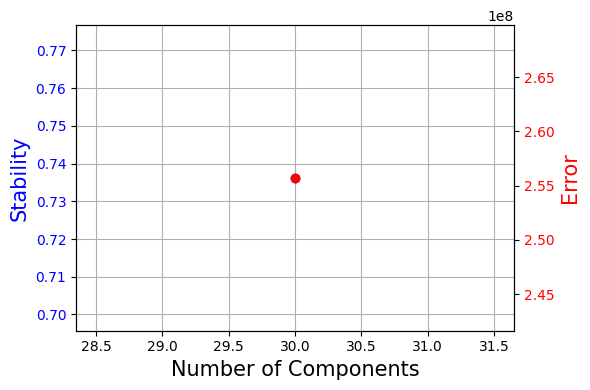

In [12]:
cnmf_obj.k_selection_plot()

In [4]:
from tqdm.auto import tqdm

def run_cnmf_consensus(cnmf_obj=None, output_dir=None, name=None, 
                       components=[7,8,9,10], density_thresholds=[0.01, 0.05, 2.0]):

    if cnmf_obj is None:
        cnmf_obj = init_cnmf_obj(output_dir=output_dir, name=name)

    for k in tqdm(components, desc='Running cNMF'):
        for thresh in density_thresholds:
            cnmf_obj.consensus(k=k, density_threshold=thresh, show_clustering=True)
    

Running cNMF:   0%|          | 0/1 [00:00<?, ?it/s]/home/users/ymo/.local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
/home/users/ymo/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
Running cNMF: 100%|██████████| 1/1 [03:46<00:00, 226.83s/it]


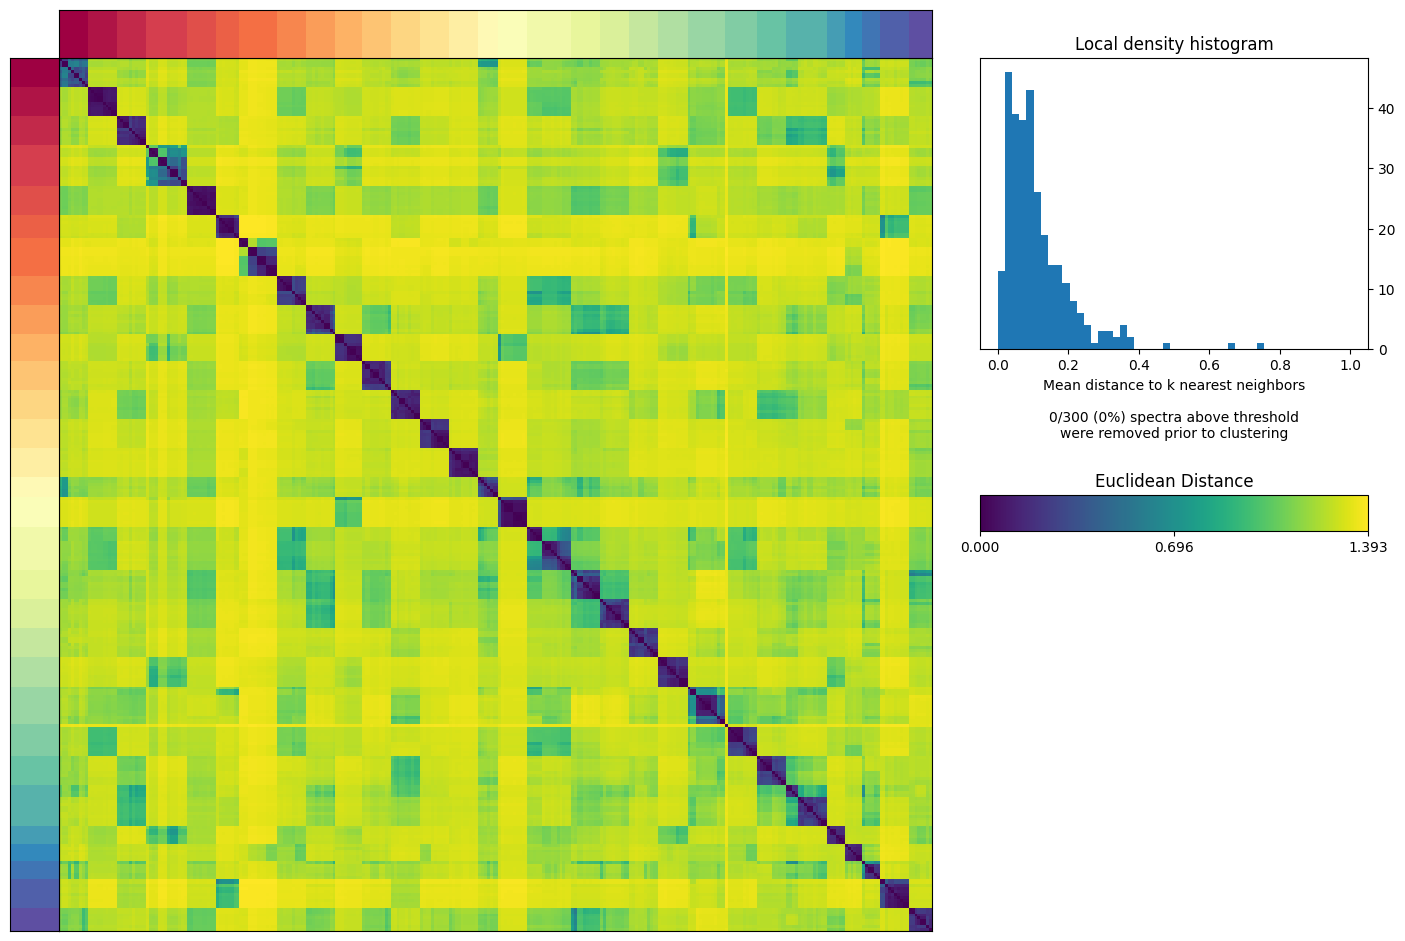

In [5]:
# Consensus plots with all k to choose thresh

run_cnmf_consensus(cnmf_obj, 
                components=K, 
                density_thresholds=[sel_thresh])

In [6]:
# Save all cNMF scores in separate mudata objects

for k in K:

    scores = pd.read_csv('{output_directory}/{run_name}/{run_name}.usages.k_{k}.dt_{sel_thresh}.consensus.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = str(sel_thresh).replace('.','_')),
                                                                                    sep='\t', index_col=0)

    loadings = pd.read_csv('{output_directory}/{run_name}/{run_name}.spectra.k_{k}.dt_{sel_thresh}.consensus.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = str(sel_thresh).replace('.','_')),
                                                                                    sep='\t', index_col=0)
    

    os.makedirs((f'{output_directory}/{run_name}/loading'), exist_ok=True)


    scores.to_csv('{output_directory}/{run_name}/loading/cNMF_scores_{k}_{sel_thresh}.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = sel_thresh), sep='\t')
    loadings.T.to_csv('{output_directory}/{run_name}/loading/cNMF_loadings_{k}_{sel_thresh}.txt'.format(     
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = sel_thresh), sep='\t')

    adata_ = anndata.read_h5ad('{output_directory}/{run_name}/cnmf_tmp/{run_name}.tpm.h5ad'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k ))
    adata_.var_names_make_unique()
    adata_.obs_names_make_unique()

    prog_data = anndata.AnnData(X=scores.values, obs=adata_.obs)
    prog_data.varm['loadings'] = loadings.values
    prog_data.uns['var_names'] = loadings.columns.values


    # Make adata
    os.makedirs((f'{output_directory}/{run_name}/prog_data'), exist_ok=True)
    prog_data.write(f'{output_directory}/{run_name}/prog_data/NMF_{k}_{sel_thresh}.h5ad'.format(
                                                                            output_directory=output_directory,
                                                                            run_name = run_name,
                                                                            k=k,
                                                                            sel_thresh = str(sel_thresh).replace('.','_')))

    # Make mdata
    mdata = muon.MuData({'rna': adata_, 'cNMF': prog_data})

    os.makedirs((f'{output_directory}/{run_name}/adata'), exist_ok=True)
    mdata.write(f'{output_directory}/{run_name}/adata/cNMF_{k}_{sel_thresh}.h5mu'.format(
                                                                            output_directory=output_directory,
                                                                            run_name = run_name,
                                                                            k=k,
                                                                            sel_thresh = str(sel_thresh).replace('.','_')))

In [75]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Runtime: {elapsed_time:.2f} seconds")

Runtime: 806.57 seconds
